Interface between python and fortran.
Documentation:
- https://numpy.org/doc/stable/f2py/usage.html
- https://pnavaro.github.io/python-notebooks/16-Fortran.html

The `f2py` works for Fortran 77, Fortran 90, Fortran 2003 and Fortran 2005, but here we use the Fortran 90. In the Fortran version more recently the package `f2py` work's different compared with the oldest versions. `f2py` facilitates creating/building Python C/API extension modules that make it possible: to call Fortran 77/90/95 external subroutines and Fortran 90/95 module subroutines as well as C functions; to access Fortran 77 COMMON blocks and Fortran 90/95 module data, including allocatable arrays from Python.

First we have to write the file with `f.90` extension.

After to write the `f.90` file, we need compile the code. To do that, we use two commands lines:

1) python -m numpy.f2py _namefile_.f90 -h _namefile_.pyf
2) python -m numpy.f2py -c _namefile_.f90 -m _namecallable_

Detail of command 1.:
- The `f2py` is the extension of numpy.
- Create signature file is saved to _namefile_.pyf with all input (IN) and output (OUT) variables.

Detail of command 2.:
- The quickest way to wrap the Fortran subroutine _namecallable_ for use in Python is to run.
- This command compiles and wraps _namefile_.f90 (-c) to create the extension module _namefile_.so (-m) in the current directory.

Now, we need to import the compiled subroutines using `import _namecallable_`. To use the callable, the command are given by 

                                OUTPUT_VARIBLES = _namecallable_._namecallable_(INPUT_VARIBLES)

----------------------------------------------------------------------------------------------------------------------------------------------

Tight-binding to Graphene:
$$h(\vec{k}) = \begin{pmatrix}
0& \Delta_{\vec{k}}\\
\Delta_{\vec{k}}^* & 0
\end{pmatrix}$$

where $\Delta_{\vec{k}} =-t(1 + 2e^{i\sqrt{3}k_x/2}cos(k_y/2))$. ($a=1$)

In the Hartree-Fock approximation, we include the electron-electron interativity term, called Hubbard term:
$$H_U = U \sum_{i} n_{i \uparrow} n_{i \downarrow} \approx \sum_i  n_{i \uparrow}\langle  n_{i \downarrow} \rangle +  n_{i \downarrow}\langle  n_{i \uparrow} \rangle - \langle  n_{i \uparrow} \rangle \langle  n_{i \downarrow} \rangle$$

$$E_U = -U \sum_j \langle n_{j\downarrow} \rangle \langle n_{j\uparrow} \rangle$$

So the total Hamiltonian are

$$H = \begin{pmatrix}
\langle  n_{a \downarrow} \rangle& \Delta_{\vec{k}} & 0 & 0\\
\Delta_{\vec{k}}^* & \langle  n_{b \downarrow} \rangle & 0 & 0\\
0&0& \langle  n_{a \uparrow} \rangle& \Delta_{\vec{k}}\\
0&0&\Delta_{\vec{k}}^* & \langle  n_{b \uparrow} \rangle\\
\end{pmatrix} + E_U$$

$E_U$ can be neglected and add in the Free-energy calculation.

The self-consistent method are given by the schematic diagram:


<p align="center">
<img src="Untitled_Workspace.png" style="width:550px;height:800px;">
</p>

In this code, we implement the density od states (DOS), chemical potential ($\mu$), new occupations ($\langle n_{i\sigma}\rangle$) and termodynamics functions (Total Energy: $E_T$, Entropy: $S$) in `FORTRAN 90`.

The diagonalization and the self-cosistent calculus are implement in `PYTHON`.

----------------------------------------------------------------------------------------------------------------------------------------------

Writing the `FORTRAN 90` parts:

We will discuss the calculation of DOS and the estimation of the Fermi energy ($E_F$):

The DOS per unit cell are given by
$$\rho(\omega) = \frac{1}{N} \sum_{\vec{k}, i, \sigma} \delta(\omega - \epsilon_{i, \sigma}(\vec{k})),$$

where $\epsilon_{i, \sigma}(\vec{k})$ are the eigenvalues for the Hamiltonian $H$, and the range of energy are given in the interval $\omega \in [\omega_{min}, \omega_{max}]$, with $\omega_{min} = \text{min}(\epsilon_{i, \sigma}(\vec{k})) - 0.5$ and $\omega_{max} = \text{max}(\epsilon_{i, \sigma}(\vec{k})) + 0.5$.

To estimate the Fermi energy ($E_F$) we do the integral
$$\bar{\omega} \leq \omega_{max}$$
$$\int_{\omega_{min}}^{\bar{\omega}} \rho(\omega ') d\omega ' = n_e \to E_F = \bar{\omega}$$

In [1]:
%%file dos.f90
subroutine dos(minimo, maximo, Nk, smearing, Nenergy, ne, edw, eup, ef)
	IMPLICIT NONE

	INTEGER, PARAMETER :: num=100 !Points of the discretization in ZB
    
    REAL(8), INTENT(IN) :: minimo
    REAL(8), INTENT(IN) :: maximo
    INTEGER, INTENT(IN) :: Nk
    REAL(8), INTENT(IN) :: smearing
    INTEGER, INTENT(IN) :: Nenergy
    REAL(8) :: ne
    REAL(8), INTENT(IN), DIMENSION(1:num,1:num,2) :: edw
    REAL(8), INTENT(IN), DIMENSION(1:num,1:num,2) :: eup
    REAL(8), INTENT(OUT) :: ef
    
    INTEGER :: x !index of in array of eigenvalues
    INTEGER :: y !index of in array of eigenvalues
    INTEGER :: inix=1
	INTEGER :: fimx=num
    INTEGER :: iniy=1 
	INTEGER :: fimy=num
    
    REAL(8), PARAMETER :: pi=DACOS(-1.d0)
    REAL(8) :: factor
    REAL(8) :: alpha1dw
	REAL(8) :: alpha2dw
	REAL(8) :: alpha1up
	REAL(8) :: alpha2up
	REAL(8) :: alpha_sum
 	REAL(8), DIMENSION(0:Nenergy) :: rho
	REAL(8) :: arg_rho
  
	INTEGER(8) :: ienergy ! indice que corre a energia
	REAL(8) :: step_energy ! passo da energy
	REAL(8), DIMENSION(0:Nenergy) :: w  ! range de energy
 
	REAL(8), DIMENSION(0:Nenergy) :: integral
 
	step_energy=((maximo+0.5d0)-(minimo-0.5d0))/Nenergy
    	
    factor=1.d0/(smearing*REAL(Nk)*DSQRT(pi))
	
	rho=0.d0
	DO ienergy=0,Nenergy
	    w(ienergy)=minimo-0.5d0+ienergy*step_energy
	    arg_rho=0.d0
	    DO y= iniy,fimy
		    DO x= inix, fimx
			    alpha1dw=DEXP(-1.d0*((w(ienergy)-edw(x,y,1))**2.d0)/(smearing**2.d0)) !Dirac delta
	    		alpha2dw=DEXP(-1.d0*((w(ienergy)-edw(x,y,2))**2.d0)/(smearing**2.d0)) !Dirac delta
		    	alpha1up=DEXP(-1.d0*((w(ienergy)-eup(x,y,1))**2.d0)/(smearing**2.d0)) !Dirac delta
    			alpha2up=DEXP(-1.d0*((w(ienergy)-eup(x,y,2))**2.d0)/(smearing**2.d0)) !Dirac delta
    			alpha_sum = alpha1dw+alpha2dw+alpha1up+alpha2up
    			arg_rho= arg_rho + alpha_sum
    		END DO
    	END DO
    	rho(ienergy)=factor*arg_rho
	END DO
	!calculando a integral de rho para encontrar ef: 
	integral = 0.d0
	DO ienergy=1,Nenergy
		integral(ienergy) = integral(ienergy-1) + (rho(ienergy)+rho(ienergy-1))
	END DO
	integral=integral*step_energy/2.d0
	DO ienergy=0,Nenergy
		IF (integral(ienergy)>=ne) THEN
			EXIT
		END IF
	END DO
	!DEFINE THE EF:
	IF (integral(ienergy)==ne) THEN
		ef=w(ienergy)
	ELSE
		ef=w(ienergy-1)+step_energy*(ne-integral(ienergy-1))/&
			&(integral(ienergy)-integral(ienergy-1))
	END IF  

end subroutine dos

Overwriting dos.f90


For chemical potential calculation, we used the **bisection method**, we define the interval $[E_F-\alpha,\cdots,E_F, \cdots, E_F+\alpha]$ with $\mu_{min}= E_F-\alpha$ and $\mu_{max} = E_F$ (or $\mu_{min}= E_F$ and $\mu_{max} = E_F+\alpha$ ), the calculation continues until $|\mu_{min}- \mu_{max}|<\epsilon_{tol}$, and $\mu = \frac{\mu_{max}+\mu_{min}}{2}$.

All the calculation we use the Fermi-Dirac distribution:
$$n_{\mu'} = \frac{1}{exp[{\beta(\epsilon_{i, \sigma}(\vec{k})-\mu')}]+1}$$

In [2]:
%%file chempot.f90
Subroutine chempot(beta, Nk, ef, ne, edw, eup, mu)
    IMPLICIT NONE

    INTEGER, PARAMETER :: num=100 !Points of the discretization in ZB
    
    REAL(8), INTENT(IN) :: BETA !1/eV
    REAL(8), INTENT(IN) :: ef, ne !Fermi energy (estimative); Numbers of electrons
    INTEGER, INTENT(IN) :: Nk
    REAL(8), INTENT(IN), DIMENSION(1:num,1:num,2) :: edw
    REAL(8), INTENT(IN), DIMENSION(1:num,1:num,2) :: eup
    REAL(8), INTENT(OUT) :: mu

	INTEGER :: kx !index of Brilloun Zone
    INTEGER :: ky !index of Brilloun Zone
	REAL(8) :: chp, chpminus, chpplus, f, fplus, fminus, ff
    REAL(8), PARAMETER :: muconv=1.d-6 !Convergence parameter
	REAL(8) :: occplus, occminus, occ
    
    INTEGER :: edgeinix=1!ZB 
	INTEGER :: edgebordax=num-1 !ZB edge
    INTEGER :: edgeiniy=1 !ZB 
	INTEGER :: edgeborday=num-1 !ZB edge
	
	chpplus=ef+1.5d0
	chpminus=ef-1.5d0
	chp=ef
	fplus=0.d0
	fminus=0.d0
	DO kx= edgeinix,edgebordax
        DO ky= edgeiniy,edgeborday
            occplus =  1.D0/(DEXP(BETA*(edw(kx,ky,1)-chpplus)) + 1.D0)+&
                    & 1.D0/(DEXP(BETA*(edw(kx,ky,2)-chpplus)) + 1.D0)+&
                    & 1.D0/(DEXP(BETA*(eup(kx,ky,1)-chpplus)) + 1.D0)+&
                    & 1.D0/(DEXP(BETA*(eup(kx,ky,2)-chpplus)) + 1.D0)
            fplus=fplus+occplus
            occminus = 1.D0/(DEXP(BETA*(edw(kx,ky,1)-chpminus)) + 1.D0)+&
                    & 1.D0/(DEXP(BETA*(edw(kx,ky,2)-chpminus)) + 1.D0)+&
                    & 1.D0/(DEXP(BETA*(eup(kx,ky,1)-chpminus)) + 1.D0)+&
                    & 1.D0/(DEXP(BETA*(eup(kx,ky,2)-chpminus)) + 1.D0)
            fminus=fminus+occminus
        END DO
	END DO
	
	fplus=(fplus/REAL(Nk))-ne
	fminus=(fminus/REAL(Nk))-ne
	ff=fplus*fminus
	IF (ff>0) THEN
		STOP
	END IF
	DO WHILE (DABS(chpplus-chpminus)>muconv)
		f=0.d0
		fminus=0.d0
		chp=0.5d0*(chpplus+chpminus)

		DO kx=edgeinix, edgebordax
            DO ky= edgeiniy,edgeborday
		    !Ocupação com muminus:
                occminus = 1.D0/(DEXP(BETA*(edw(kx,ky,1)-chpminus)) + 1.D0)+&
                        & 1.D0/(DEXP(BETA*(edw(kx,ky,2)-chpminus)) + 1.D0)+&
                        & 1.D0/(DEXP(BETA*(eup(kx,ky,1)-chpminus)) + 1.D0)+&
                        & 1.D0/(DEXP(BETA*(eup(kx,ky,2)-chpminus)) + 1.D0)
                fminus=fminus+occminus
                !Ocupação com mu:
                occ=  1.D0/(DEXP(BETA*(edw(kx,ky,1)-chp)) + 1.D0)+&
                    & 1.D0/(DEXP(BETA*(edw(kx,ky,2)-chp)) + 1.D0)+&
                    & 1.D0/(DEXP(BETA*(eup(kx,ky,1)-chp)) + 1.D0)+&
                    & 1.D0/(DEXP(BETA*(eup(kx,ky,2)-chp)) + 1.D0)
            f=f+occ
            END DO
        END DO   ! Fim do K

		fminus=(fminus/REAL(Nk))-ne
		f=(f/REAL(Nk))-ne

		IF (fminus*f<0) THEN
		    chpplus=chp
		ELSE
			chpminus=chp
		END IF
	END DO   ! Fim do while
	mu=0.5d0*(chpplus+chpminus)
end subroutine chempot

Overwriting chempot.f90


With the chemical potential, we can calculate the new occupations for each sites to spin-up and spin-down.
$$\langle n_{j\sigma} \rangle = \frac{1}{N} \sum_{\vec{k}, i=1,2} |A^i_{j, \sigma}(\vec{k})|^2 \frac{1}{exp[{\beta(\epsilon_{i, \sigma}(\vec{k})-\mu)}]+1}$$

where $A^i_{j, \sigma}(\vec{k})$ are the elements of eigenvector of the Hamiltonian $H$.

In [3]:
%%file newocc.f90
Subroutine occupation(beta, Nk, mu, edw, eup, pdw0, pdw1, pup0, pup1, new_nadw, new_nbdw, new_naup, new_nbup)
    IMPLICIT NONE

    INTEGER, PARAMETER :: num=100 !Points of the discretization in ZB
    
    REAL(8), INTENT(IN) :: BETA !1/eV
    INTEGER, INTENT(IN) :: Nk
    REAL(8), INTENT(IN) :: mu ! chemical potential
    REAL(8), INTENT(IN), DIMENSION(1:num,1:num,2) :: edw
    REAL(8), INTENT(IN), DIMENSION(1:num,1:num,2) :: eup
    COMPLEX(8), DIMENSION(1:num*num,2) :: pdw0
    COMPLEX(8), DIMENSION(1:num*num,2) :: pdw1
    COMPLEX(8), DIMENSION(1:num*num,2) :: pup0
    COMPLEX(8), DIMENSION(1:num*num,2) :: pup1
    REAL(8), INTENT(OUT) :: new_nadw
    REAL(8), INTENT(OUT) :: new_nbdw
    REAL(8), INTENT(OUT) :: new_naup
    REAL(8), INTENT(OUT) :: new_nbup

	INTEGER :: kx !index of Brilloun Zone
    INTEGER :: ky !index of Brilloun Zone
    
    INTEGER :: edgeinix=1!ZB 
	INTEGER :: edgebordax=num-1 !ZB edge
    INTEGER :: edgeiniy=1 !ZB 
	INTEGER :: edgeborday=num-1 !ZB edge
 
    INTEGER :: count
 
    REAL(8) :: fadw
    REAL(8) :: fbdw
    REAL(8) :: faup
    REAL(8) :: fbup
    
    new_nadw = 0.d0
    new_naup = 0.d0
    new_nbdw = 0.d0
    new_nbup = 0.d0
    
    count = 0
    
    DO ky= edgeiniy,edgeborday
		DO kx= edgeinix, edgebordax
			fadw = 1.D0/(DEXP(beta*(edw(kx,ky,1)-mu)) + 1.D0)
			fbdw = 1.D0/(DEXP(beta*(edw(kx,ky,2)-mu)) + 1.D0)
			faup = 1.D0/(DEXP(beta*(eup(kx,ky,1)-mu)) + 1.D0)
			fbup = 1.D0/(DEXP(beta*(eup(kx,ky,2)-mu)) + 1.D0)
								
			new_nadw = new_nadw+fadw*DREAL(pdw0(count,1)*DCONJG(pdw0(count,1)))/(Nk) &
					&+ fbdw*DREAL(pdw1(count,1)*DCONJG(pdw1(count,1)))/(Nk)
			new_nbdw = new_nbdw+fadw*DREAL(pdw0(count,2)*DCONJG(pdw0(count,2)))/(Nk) &
					&+ fbdw*DREAL(pdw1(count,2)*DCONJG(pdw1(count,2)))/(Nk)
			new_naup = new_naup+faup*DREAL(pup0(count,1)*DCONJG(pup0(count,1)))/(Nk) &
					&+ fbup*DREAL(pup1(count,1)*DCONJG(pup1(count,1)))/(Nk)
			new_nbup = new_nbup+faup*DREAL(pup0(count,2)*DCONJG(pup0(count,2)))/(Nk) &
					&+ fbup*DREAL(pup1(count,2)*DCONJG(pup1(count,2)))/(Nk)
     
            count = count + 1
		ENDDO
	ENDDO
 

end subroutine occupation

Overwriting newocc.f90


The total energy are given by
$$E_T = \sum_{\vec{k}, i, \sigma} \epsilon_{i, \sigma}(\vec{k})\frac{1}{exp[{\beta(\epsilon_{i, \sigma}(\vec{k})-\mu)}]+1}$$

The entropy are given by
$$S(T) = -k_B \int_{-\infty}^{\infty} d\omega \rho(\omega) \big\{ f(\omega) ln[f(\omega)] + [1-f(\omega)] ln[1-f(\omega)] \big\}$$

where
$$f(\omega) = \frac{1}{exp[{\beta(\omega-\mu)}]+1} \text{ and } \beta = \frac{1}{k_BT}$$

The Free-Energy are given by
$$F = E_T + E_U - TS(T)$$

and 
$$E_U = -U \sum_j \langle n_{j\downarrow} \rangle \langle n_{j\uparrow} \rangle$$

In [4]:
%%file termo.f90
subroutine termo(beta, Nk, mu, edw, eup, Et, TS)
	IMPLICIT NONE

    INTEGER, PARAMETER :: num=100 !Points of the discretization in ZB
    
    REAL(8), INTENT(IN) :: BETA !1/eV
    INTEGER, INTENT(IN) :: Nk
    REAL(8), INTENT(IN) :: mu ! chemical potential
    REAL(8), INTENT(IN), DIMENSION(1:num,1:num,2) :: edw
    REAL(8), INTENT(IN), DIMENSION(1:num,1:num,2) :: eup
    REAL(8), INTENT(OUT) :: Et
    REAL(8), INTENT(OUT) :: TS
    
    INTEGER :: x !index of in array of eigenvalues
    INTEGER :: y !index of in array of eigenvalues
    INTEGER :: inix=1
	INTEGER :: fimx=num
    INTEGER :: iniy=1 
	INTEGER :: fimy=num

	REAL(8) :: stemp
 	REAL(8) :: sadw
	REAL(8) :: sbdw
	REAL(8) :: saup
	REAL(8) :: sbup
	REAL(8) :: etemp

	REAL(8) :: fadw
 	REAL(8) :: fbdw
 	REAL(8) :: faup
	REAL(8) :: fbup

    stemp=0.d0
	sadw=0.d0
	sbdw=0.d0
	saup=0.d0
	sbup=0.d0
	etemp=0.d0
	DO y= iniy,fimy
		DO x= inix, fimx
			fadw = 1.D0/(DEXP(BETA*(edw(x,y,1)-mu)) + 1.D0)
			fbdw = 1.D0/(DEXP(BETA*(edw(x,y,2)-mu)) + 1.D0)
			faup = 1.D0/(DEXP(BETA*(eup(x,y,1)-mu)) + 1.D0)
			fbup = 1.D0/(DEXP(BETA*(eup(x,y,2)-mu)) + 1.D0)
				
			etemp = etemp+ fadw*edw(x,y,1) + fbdw*edw(x,y,2)+&
						 & faup*eup(x,y,1) + fbup*eup(x,y,2)
						
			IF ((fadw>1.d-100).AND.(1.d0-fadw>1.d-100)) THEN
				sadw=sadw+(DLOG(fadw)*fadw+ &
				&DLOG(1.d0-fadw)*(1.d0-fadw))
			END IF	
			IF ((fbdw>1.d-100).AND.(1.d0-fbdw>1.d-100)) THEN
				sbdw=sbdw+(DLOG(fbdw)*fbdw+ &
				&DLOG(1.d0-fbdw)*(1.d0-fbdw))
			END IF	
			IF ((faup>1.d-100).AND.(1.d0-faup>1.d-100)) THEN
				saup=saup+(DLOG(faup)*faup+ &
				&DLOG(1.d0-faup)*(1.d0-faup))
			END IF	
			IF ((fbup>1.d-100).AND.(1.d0-fbup>1.d-100)) THEN
				sbup=sbup+(DLOG(fbup)*fbup+ &
				&DLOG(1.d0-fbup)*(1.d0-fbup))
			END IF		  
		END DO
	END DO
	Et = etemp/(Nk)
	stemp=sadw+sbdw+saup+sbup
	TS = -stemp/(Nk*BETA) 

end subroutine

Overwriting termo.f90


----------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble' : r'\usepackage{amsmath}'})

Compiling `FORTRAN 90` parts:

In [ ]:
import numpy.f2py

!python -m numpy.f2py dos.f90 -h dos.pyf
!python -m numpy.f2py -c dos.f90 -m dos

!python -m numpy.f2py chempot.f90 -h chempot.pyf
!python -m numpy.f2py -c chempot.f90 -m chempot

!python -m numpy.f2py newocc.f90 -h newocc.pyf
!python -m numpy.f2py -c newocc.f90 -m occupation

!python -m numpy.f2py termo.f90 -h termo.pyf
!python -m numpy.f2py -c termo.f90 -m termo

Importing subroutines from `FORTRAN 90`:

In [7]:
import dos
#print(dos.dos.__doc__)
import chempot
#print(chempot.chempot.__doc__)
import occupation
#print(occupation.occupation.__doc__)
import termo
#print(termo.termo.__doc__)

----------------------------------------------------------------------------------------------------------------------------------------------

Define the block-diagonal spin-down (-up) Hamiltonian:

In [8]:
def hdw(t, U, kx, ky, naup, nbup):
    dk =-t* (1 + 2*np.exp(1j*np.sqrt(3)*kx/2)*np.cos(ky/2))
    dck = np.conjugate(dk)
    h = dk*np.eye(2, k=1) + dck* np.eye(2, k=-1) + U*np.diag([naup,nbup])
    edw, psidw = np.linalg.eigh(h)
    return edw, psidw

def hup(t, U, kx, ky, nadw, nbdw):
    dk =-t* (1 + 2*np.exp(1j*np.sqrt(3)*kx/2)*np.cos(ky/2))
    dck = np.conjugate(dk)
    h = dk*np.eye(2, k=1) + dck* np.eye(2, k=-1) + U*np.diag([nadw,nbdw])
    eup, psiup = np.linalg.eigh(h)
    return eup, psiup

Initial parameters:

In [9]:
N = 100
Nk = int(N*N)
kx = np.linspace(-np.pi, np.pi, N, endpoint=False)
ky = np.linspace(-np.pi, np.pi, N, endpoint=False)
t = 0.1
U = 50 * t
ne = 1
occ = 1e-3
smearing = 0.01
Nenergy = 5*N
temperature = 300
kb = 8.617e-5
beta = 1/(kb*temperature)
delta = 0.05*ne

Differents initial inputs occupations:

In [10]:
# nadw, nbdw, naup, nbup
list_key = ["Ferromagnetic", "Paramagnetic", "Antiferromagnetic"]
dict = {"Paramagnetic": [ne/4,ne/4,ne/4,ne/4],
        "Ferromagnetic": [ne/4-delta,ne/4-delta,ne/4+delta,ne/4+delta],
        "Antiferromagnetic": [ne/4+delta,ne/4-delta,ne/4-delta,ne/4+delta]
}

Self-consistent method:

In [11]:
print('Considering:', 'U =', U, 'unit in t;', 'ne =', ne, '; at temperature =', temperature, 'K')
occ_nadw, occ_nbdw, occ_naup, occ_nbup = [], [], [], []
F = [] #array where I salve the free energy
for key in list_key: #Change the occupation input occupation
    print('input magnetic phase:', key)
    nadw, nbdw, naup, nbup = dict[key][0], dict[key][1], dict[key][2], dict[key][3]
    initial = True
    new_nadw, new_nbdw, new_naup, new_nbup = 0, 0, 0, 0
    
    while((nadw-new_nadw)>occ or (nbdw-new_nbdw)>occ or (naup-new_naup)>occ or (nbup-new_nbup)>occ): #Self-consistent method
        if(initial==True):
            nadw = nadw
            nbdw = nbdw
            naup = naup
            nbup = nbup
        else:
            nadw = new_nadw
            nbdw = new_nbdw
            naup = new_naup
            nbup = new_nbup
            
        # Now build the diagonalization in fortran:
        edw = np.zeros((N,N, 2))
        eup = np.zeros((N,N, 2))
        pdw0 = []
        pup0 = []
        pdw1 = []
        pup1 = []
        for x in range(len(kx)):
            for y in range(len(ky)):
                DW, PDW = hdw(t, U, kx[x], ky[y], naup, nbup)
                edw[x][y][0] = DW[0]
                edw[x][y][1] = DW[1]
                pdw0.append(PDW[:,0])
                pdw1.append(PDW[:,1])
                UP, PUP = hup(t, U, kx[x], ky[y], nadw, nbdw)
                eup[x][y][0] = UP[0]
                eup[x][y][1] = UP[1]
                pup0.append(PUP[:,0])
                pup1.append(PUP[:,1])
                
        minimo = np.array([edw.min(), eup.min()]).min() # minimo de energia
        maximo = np.array([edw.max(), eup.max()]).max() # maximo de energia
        # calcula DOS e estima um valor de ef na para ne elétrons:
        ef = dos.dos(minimo, maximo, Nk, smearing, Nenergy, ne, edw, eup) 
        
        # calcula Potencial Químico (mu) a partir do chute de ef:
        mu = chempot.chempot(beta, Nk, ef, ne, edw, eup)
        
        # calcula novas ocupações:
        new_nadw, new_nbdw, new_naup, new_nbup = occupation.occupation(beta, Nk, mu, edw, eup, pdw0, pdw1, pup0, pup1)
                    
        initial = False
        
    occ_nadw.append(new_nadw)
    occ_nbdw.append(new_nbdw)
    occ_naup.append(new_naup)
    occ_nbup.append(new_nbup)
    Ucte = -U*(new_nadw*new_naup + new_nbdw*new_nbup)
    Et, TS = termo.termo(beta, Nk, mu, edw, eup)
    Et = Et + Ucte
    F.append(Et - TS)
    
    print('In the case', key, 'the Free energy is:', Et - TS)
    print('The converged occupation is:')
    print('new_nadw =', round(new_nadw,2), 'new_nbdw =', round(new_nbdw,2), 'new_naup =', round(new_naup,2), 'new_nbup =', round(new_nbup,2), '\n')
    

Considering: U = 5.0 unit in t; ne = 1 ; at temperature = 300 K
input magnetic phase: Ferromagnetic
In the case Ferromagnetic the Free energy is: -0.17150925129657824
The converged occupation is:
new_nadw = 0.0 new_nbdw = 0.0 new_naup = 0.5 new_nbup = 0.5 

input magnetic phase: Paramagnetic
In the case Paramagnetic the Free energy is: 0.3895984906896269
The converged occupation is:
new_nadw = 0.25 new_nbdw = 0.25 new_naup = 0.25 new_nbup = 0.25 

input magnetic phase: Antiferromagnetic
In the case Antiferromagnetic the Free energy is: -0.05004389007135887
The converged occupation is:
new_nadw = 0.5 new_nbdw = 0.0 new_naup = 0.0 new_nbup = 0.5 



----------------------------------------------------------------------------------------------------------------------------------------------

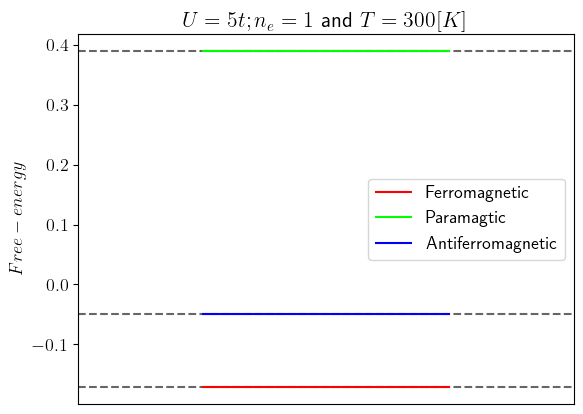

In [14]:
plt.hlines(y = F[0], xmin = 1, xmax = 2, color='red', label='Ferromagnetic')
plt.hlines(y = F[0], xmin = 0.5, xmax = 2.5, color='black', linestyles='--', zorder=1, alpha=0.6)
plt.hlines(y = F[1], xmin = 1, xmax = 2, color='lime', label='Paramagtic')
plt.hlines(y = F[1], xmin = 0.5, xmax = 2.5, color='black', linestyles='--', zorder=1, alpha=0.6)
plt.hlines(y = F[2], xmin = 1, xmax = 2, color='blue', label='Antiferromagnetic')
plt.hlines(y = F[2], xmin = 0.5, xmax = 2.5, color='black', linestyles='--', zorder=1, alpha=0.6)
plt.xlim(0.5, 2.5)
plt.xticks([])
plt.title(r'$U = 5 t; n_e = 1 \text{ and } T = 300 [K]$')
plt.ylabel(r'$Free-energy$')
plt.legend(loc='center right')
plt.show()

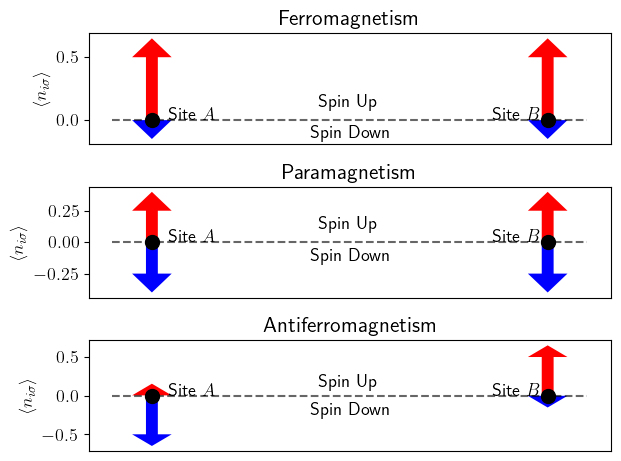

In [15]:
feadw, paadw, anadw = occ_nadw[0], occ_nadw[1], occ_nadw[2]  
febdw, pabdw, anbdw = occ_nbdw[0], occ_nbdw[1], occ_nbdw[2]
feaup, paaup, anaup = occ_naup[0], occ_naup[1], occ_naup[2]
febup, pabup, anbup = occ_nbup[0], occ_nbup[1], occ_nbup[2]

fig, ax = plt.subplots(nrows=3, ncols=1, layout=None, sharex=True)
# Case Ferromagnetic
ax[0].arrow(0, 0, 0, -feadw,width=.003, head_width=0.01, head_length=0.15,facecolor='blue', edgecolor='none') #a
ax[0].arrow(0, 0, 0, feaup, width=.003, head_width=0.01, head_length=0.15, facecolor='red', edgecolor='none') #a
ax[0].arrow(0.1, 0, 0, -febdw, width=.003, head_width=0.01, head_length=0.15, facecolor='blue', edgecolor='none') #b 
ax[0].arrow(0.1, 0, 0, febup, width=.003, head_width=0.01, head_length=0.15, facecolor='red', edgecolor='none') #b
ax[0].scatter(0, 0, s=100, color='black')
ax[0].scatter(0.1, 0, s=100, color='black')
ax[0].text(0.004, 0, r'Site $A$')
ax[0].text(0.086, 0, r'Site $B$')
ax[0].hlines(y = 0, xmin = -0.01, xmax = 0.11, color='black', linestyles='--', zorder=1, alpha=0.6)
ax[0].text(0.042, 0.1, 'Spin Up')
ax[0].text(0.04, -0.15, 'Spin Down')
ax[0].set_ylabel(r'$\langle n_{i\sigma} \rangle$')
ax[0].set_title('Ferromagnetism')

# Case Paramagnetic
ax[1].arrow(0, 0, 0, -paadw, width=.003, head_width=0.01, head_length=0.15,facecolor='blue', edgecolor='none') #a
ax[1].arrow(0, 0, 0, paaup, width=.003, head_width=0.01, head_length=0.15, facecolor='red', edgecolor='none') #a
ax[1].arrow(0.1, 0, 0, -pabdw,width=.003, head_width=0.01, head_length=0.15, facecolor='blue', edgecolor='none') #b 
ax[1].arrow(0.1, 0, 0, pabup, width=.003, head_width=0.01, head_length=0.15, facecolor='red', edgecolor='none') #b
ax[1].scatter(0, 0, s=100, color='black')
ax[1].scatter(0.1, 0, s=100, color='black')
ax[1].text(0.004, 0, r'Site $A$')
ax[1].text(0.086, 0, r'Site $B$')
ax[1].hlines(y = 0, xmin = -0.01, xmax = 0.11, color='black', linestyles='--', zorder=1, alpha=0.6)
ax[1].text(0.042, 0.1, 'Spin Up')
ax[1].text(0.04, -0.15, 'Spin Down')
ax[1].set_ylabel(r'$\langle n_{i\sigma} \rangle$')
ax[1].set_title('Paramagnetism')

# Case Paramagnetic
ax[2].arrow(0, 0, 0, -anadw, width=.003, head_width=0.01, head_length=0.15,facecolor='blue', edgecolor='none') #a
ax[2].arrow(0, 0, 0, anaup,width=.003, head_width=0.01, head_length=0.15, facecolor='red', edgecolor='none') #a
ax[2].arrow(0.1, 0, 0, -anbdw, width=.003, head_width=0.01, head_length=0.15, facecolor='blue', edgecolor='none') #b 
ax[2].arrow(0.1, 0, 0, anbup, width=.003, head_width=0.01, head_length=0.15, facecolor='red', edgecolor='none') #b
ax[2].scatter(0, 0, s=100, color='black')
ax[2].scatter(0.1, 0, s=100, color='black')
ax[2].text(0.004, 0, r'Site $A$')
ax[2].text(0.086, 0, r'Site $B$')
ax[2].hlines(y = 0, xmin = -0.01, xmax = 0.11, color='black', linestyles='--', zorder=1, alpha=0.6)
ax[2].text(0.042, 0.1, 'Spin Up')
ax[2].text(0.04, -0.25, 'Spin Down')
ax[2].set_ylabel(r'$\langle n_{i\sigma} \rangle$')
ax[2].set_title('Antiferromagnetism')
ax[2].set_xticks([])

plt.tight_layout()
plt.show()